# Проектная работа

# Анализ бизнес-показателей

## Описание проекта

Развлекательное приложение Procrastinate Pro+ несмотря на огромные вложения в рекламу, последнее время терпит убытки.

Цель — разобраться в причинах и помочь компании выйти в плюс.

Задачи:

1. Понять откуда приходят пользователи и какими устройствами они пользуются.
2. Расчитать сколько стоит привлечение пользователей из различных рекламных каналов.
3. Расчитать сколько денег приносит каждый клиент.
4. Понять когда расходы на привлечение клиента окупаются.
5. Определить какие факторы мешают привлечению клиентов.

## Описание данных

Три датасета: 

Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:

1. User Id — уникальный идентификатор пользователя,
2. Region — страна пользователя,
3. Device — тип устройства пользователя,
4. Channel — идентификатор источника перехода,
5. Session Start — дата и время начала сессии,
6. Session End — дата и время окончания сессии.

Структура orders_info_short.csv:

1. User Id — уникальный идентификатор пользователя,
2. Event Dt — дата и время покупки,
3. Revenue — сумма заказа.

Структура costs_info_short.csv:

1. dt — дата проведения рекламной кампании,
2. Channel — идентификатор рекламного источника,
3. costs — расходы на эту кампанию.

# Ход работы

### Шаг 1. Загрузить данные и подготовить их к анализу.

### Шаг 2. Исследовательский анализ данных.

Составить профили пользователей. Определить минимальную дату привлечения пользователей.

Выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.

Узнать, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.

Изучить рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. 

### Шаг 3. Маркетинг.

Посчитать общую сумму расходов на маркетинг. Выяснить, как траты распределены по рекламным источникам.

### Шаг 4. Оценить окупаемость рекламы

Проанализировать окупаемость рекламы. На календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

Проанализировать окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

Проверить конверсию пользователей и динамику её изменения. 

### Шаг 5. Выводы

## Загрузить данные и подготовить их к анализу

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [6]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [7]:
display(visits.duplicated().sum())
display(orders.duplicated().sum())
display(costs.duplicated().sum())

0

0

0

- Данные загружены, дубликатов и пропусков нет, значения дат поправлены.

## Исследовательский анализ данных


Профили пользователей:

In [8]:
def get_profiles(visits, orders):

    profiles = (
        visits.sort_values(by=['User Id', 'Session Start'])
        .groupby('User Id')
        .agg(
            {
                'Session Start': 'first',
                'Channel': 'first',
                'Device': 'first',
                'Region': 'first',
            }
        )
        .rename(columns={'Session Start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
   
    profiles['payer'] = profiles['User Id'].isin(orders['User Id'].unique()) 

    return profiles

In [9]:
profiles_first = get_profiles(visits, orders)
profiles_first.sample(5)

,User Id,first_ts,Channel,Device,Region,dt,month,payer
85068,565741409734,2019-08-18 20:57:50,organic,Android,United States,2019-08-18,2019-08-01,False
59845,396924943730,2019-05-10 16:05:04,organic,Mac,United States,2019-05-10,2019-05-01,False
3574,23967046514,2019-10-16 08:19:05,YRabbit,iPhone,United States,2019-10-16,2019-10-01,False
32938,219075011738,2019-09-04 23:40:47,WahooNetBanner,PC,France,2019-09-04,2019-09-01,False
120998,806603564662,2019-05-15 22:27:58,organic,Mac,United States,2019-05-15,2019-05-01,False


Из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей:

In [10]:
profiles_first.groupby('Region').agg({'User Id': 'nunique', 'payer': 'mean'}).sort_values(by = 'payer', ascending = False)

,User Id,payer
Region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


- Больше всего платящих пользователей в США, меньше всего во Франции.

Какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи:

In [11]:
profiles_first.groupby('Device').agg({'User Id': 'nunique', 'payer': 'mean'}).sort_values(by = 'payer', ascending = False)

,User Id,payer
Device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


- Больше всего платящих пользователей пользуются устройствами Mac, меньше всего PC.

Рекламные источники привлечения, из которых пришло больше всего платящих пользователей:

In [12]:
profiles_first.groupby('Channel').agg({'User Id': 'nunique', 'payer': 'mean'}).sort_values(by = 'payer', ascending = False)

,User Id,payer
Channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


- Из FaceBoom пришло больше всего платящих пользователей.

## Маркетинг



Общая сумма расходов на маркетинг:

In [13]:
round(costs['costs'].sum(), 2)

105497.3

- Общая сумма расходов на маркетинг составила 105497.3$.

Как траты распределены по рекламным источникам:

In [14]:
costs.groupby('Channel').agg({'costs': 'sum'}).sort_values(by=['costs'], ascending=False)

,costs
Channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


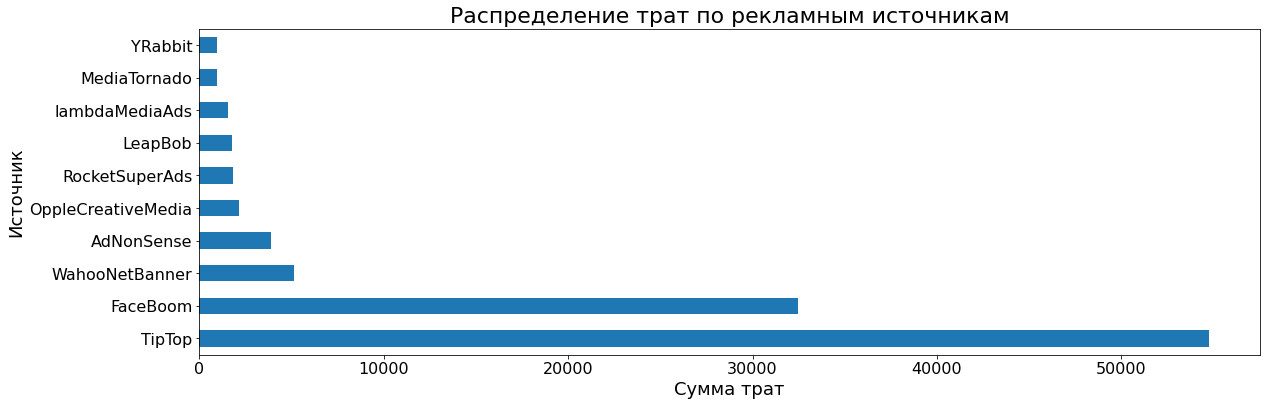

In [15]:
c_h = costs.groupby('Channel').agg({'costs': 'sum'}).sort_values(by=['costs'], ascending=False)
c_h.plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)
plt.title('Распределение трат по рекламным источникам', 
          fontsize = 22, color = 'Black')
plt.xlabel('Сумма трат', fontsize = 18, color = 'Black')
plt.ylabel('Источник', fontsize = 18, color = 'Black')
plt.show()

- Больше всего на маркетинг потратили TipTop, меньше всего YRabbit.

In [16]:
costs['week'] = costs['dt'].dt.isocalendar().week
costs.sample(5)

,dt,Channel,costs,week
164,2019-10-12,FaceBoom,216.70,41
1238,2019-10-06,LeapBob,13.65,40
134,2019-09-12,FaceBoom,128.70,37
162,2019-10-10,FaceBoom,176.00,41
1619,2019-10-27,WahooNetBanner,42.00,43


In [17]:
costs['month'] = costs['dt'].dt.month
costs.sample(5)

,dt,Channel,costs,week,month
110,2019-08-19,FaceBoom,228.80,34,8
1315,2019-06-25,OppleCreativeMedia,12.25,26,6
1017,2019-08-26,AdNonSense,17.85,35,8
1052,2019-09-30,AdNonSense,27.30,40,9
1145,2019-07-05,LeapBob,12.39,27,7


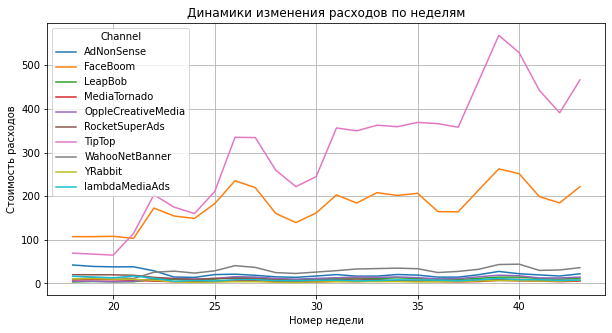

In [18]:
costs.pivot_table(
    index='week', columns='Channel', values='costs', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Стоимость расходов')
plt.xlabel('Номер недели')
plt.title('Динамики изменения расходов по неделям')
plt.show()

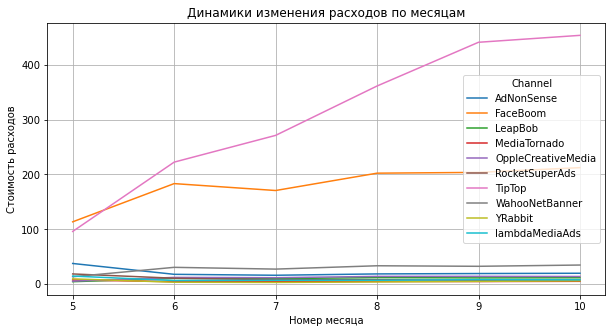

In [19]:
costs.pivot_table(
    index='month', columns='Channel', values='costs', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Стоимость расходов')
plt.xlabel('Номер месяца')
plt.title('Динамики изменения расходов по месяцам')
plt.show()

- AdNonSense вкладывают постепенно больше денег в маркетинг, остальные с течением времиени вкладывают примерно одинаковые суммы. 

Строимость привлечения одного пользователя (CAC) из каждого источника:

In [20]:
def get_profiles_cac(visits, orders, costs):
    
    profiles = (
        visits.sort_values(by=['User Id', 'Session Start'])
        .groupby('User Id')
        .agg(
            {
                'Session Start': 'first',
                'Channel': 'first',
                'Device': 'first',
                'Region': 'first',
            }
        )
        .rename(columns={'Session Start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles["weeknum"] = profiles['first_ts'].dt.isocalendar().week

    profiles['payer'] = profiles['User Id'].isin(orders['User Id'].unique())

    new_users = (
        profiles.groupby(['dt', 'Channel'])
        .agg({'User Id': 'nunique'})
        .rename(columns={'User Id': 'unique_users'})
        .reset_index()
    )
 
    new_users['dt'] = pd.to_datetime(new_users['dt'], utc=True)
    costs['dt'] = pd.to_datetime(costs['dt'], utc=True)

    costs = costs.merge(new_users, on=['dt', 'Channel'], how='left')

    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    
    profiles['dt'] = pd.to_datetime(profiles['dt'], utc=True)

    profiles = profiles.merge(
        costs[['dt', 'Channel', 'acquisition_cost']],
        on=['dt', 'Channel'],
        how='left',
    )

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [21]:
df_cac = get_profiles_cac(visits, orders, costs)
df_cac.sample(5)

,User Id,first_ts,Channel,Device,Region,dt,month,weeknum,payer,acquisition_cost
10434,69463800147,2019-09-03 17:48:03,FaceBoom,PC,United States,2019-09-03 00:00:00+00:00,2019-09-01,36,False,1.130769
5762,38612598860,2019-06-06 00:26:58,LeapBob,PC,France,2019-06-06 00:00:00+00:00,2019-06-01,23,False,0.214375
91060,606035884593,2019-06-07 12:54:12,WahooNetBanner,Android,France,2019-06-07 00:00:00+00:00,2019-06-01,23,False,0.600000
93608,623252727455,2019-05-30 01:05:00,organic,Android,Germany,2019-05-30 00:00:00+00:00,2019-05-01,22,False,0.000000
106740,711827080914,2019-05-11 22:39:30,FaceBoom,Android,United States,2019-05-11 00:00:00+00:00,2019-05-01,19,False,1.128205


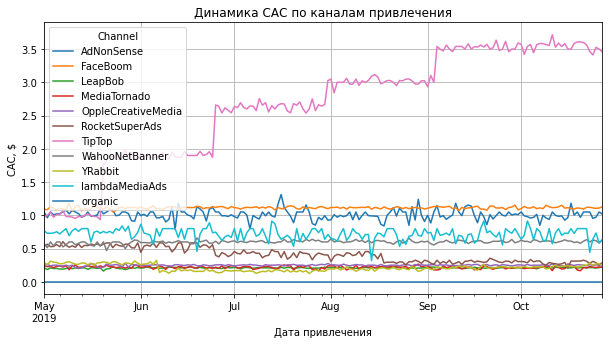

In [22]:
df_cac.pivot_table(
    index='dt', columns='Channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

 - CAC постепенно повышается у TipTop.

## Оценка окупаемости рекламы


### Конверсия пользователей и динамика её изменения, а также удержание пользователей

In [23]:
observation_date = pd.to_datetime(datetime(2019, 11, 1).date(), utc=True)
observation_date

Timestamp('2019-11-01 00:00:00+0000', tz='UTC')

In [24]:
df_cac2 = df_cac[df_cac['Channel'] != 'organic']
display(df_cac2.sample(5, random_state=1))
display(df_cac.info())
display(df_cac2.info())

,User Id,first_ts,Channel,Device,Region,dt,month,weeknum,payer,acquisition_cost
48344,320345734522,2019-05-12 15:31:36,FaceBoom,iPhone,United States,2019-05-12 00:00:00+00:00,2019-05-01,19,False,1.150575
37339,247802576178,2019-09-24 11:28:52,TipTop,iPhone,United States,2019-09-24 00:00:00+00:00,2019-09-01,39,False,3.478125
24994,166721405111,2019-10-04 18:19:38,LeapBob,iPhone,Germany,2019-10-04 00:00:00+00:00,2019-10-01,40,False,0.210000
116033,773199226768,2019-08-15 14:37:48,LeapBob,Android,France,2019-08-15 00:00:00+00:00,2019-08-01,33,False,0.214468
80493,534631256082,2019-07-30 15:42:13,TipTop,iPhone,United States,2019-07-30 00:00:00+00:00,2019-07-01,31,False,2.667241


<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   User Id           150008 non-null  int64              
 1   first_ts          150008 non-null  datetime64[ns]     
 2   Channel           150008 non-null  object             
 3   Device            150008 non-null  object             
 4   Region            150008 non-null  object             
 5   dt                150008 non-null  datetime64[ns, UTC]
 6   month             150008 non-null  datetime64[ns]     
 7   weeknum           150008 non-null  UInt32             
 8   payer             150008 non-null  bool               
 9   acquisition_cost  150008 non-null  float64            
dtypes: UInt32(1), bool(1), datetime64[ns, UTC](1), datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 11.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93569 entries, 0 to 150006
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   User Id           93569 non-null  int64              
 1   first_ts          93569 non-null  datetime64[ns]     
 2   Channel           93569 non-null  object             
 3   Device            93569 non-null  object             
 4   Region            93569 non-null  object             
 5   dt                93569 non-null  datetime64[ns, UTC]
 6   month             93569 non-null  datetime64[ns]     
 7   weeknum           93569 non-null  UInt32             
 8   payer             93569 non-null  bool               
 9   acquisition_cost  93569 non-null  float64            
dtypes: UInt32(1), bool(1), datetime64[ns, UTC](1), datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 7.0+ MB


None

In [25]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [26]:
def get_conversion(
    df_cac,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = df_cac.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        orders.sort_values(by=['User Id', 'Event Dt'])
        .groupby('User Id')
        .agg({'Event Dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['User Id', 'Event Dt']], on='User Id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['Event Dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):

        result = df.pivot_table(
            index=dims, columns='lifetime', values='User Id', aggfunc='nunique'
        )

        result = result.fillna(0).cumsum(axis = 1)

        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
 
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

In [27]:
conversion_raw, conversion, conversion_history = get_conversion(
    df_cac2, orders, observation_date, 14, dimensions=['Channel']
)

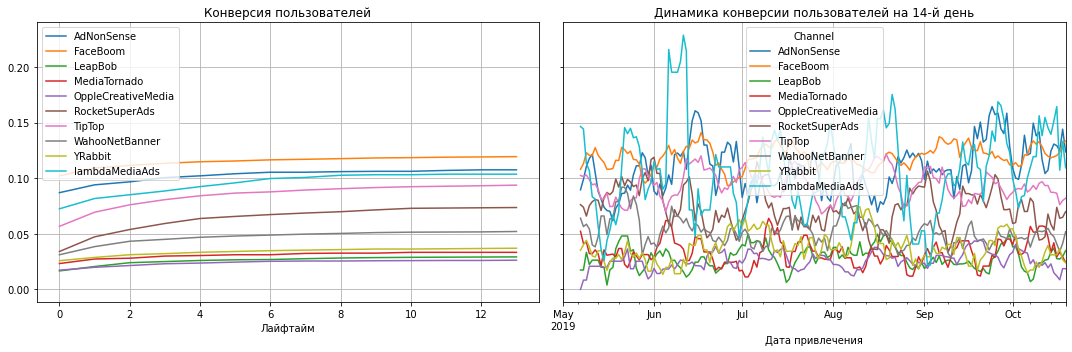

In [28]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


plot_conversion(conversion, conversion_history, 14) 

- Конверсия по каналам привлечения выше всего у FaceBoom, а у OppleCreativeMedia ниже всего.

In [29]:
conversion_raw, conversion, conversion_history = get_conversion(
    df_cac2, orders, observation_date, 14, dimensions=['Device']
)

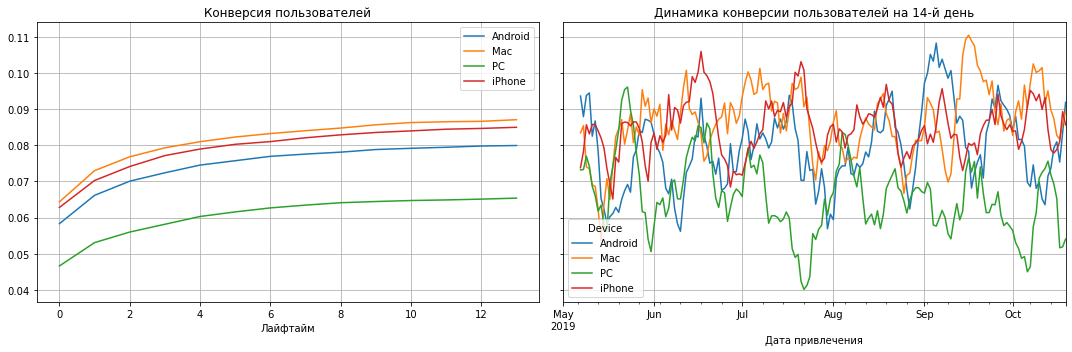

In [30]:
plot_conversion(conversion, conversion_history, 14)

- Конверсия по устройствам выше всего у Mac, а ниже всего у PC.

In [31]:
conversion_raw, conversion, conversion_history = get_conversion(
    df_cac2, orders, observation_date, 14, dimensions=['Region']
)

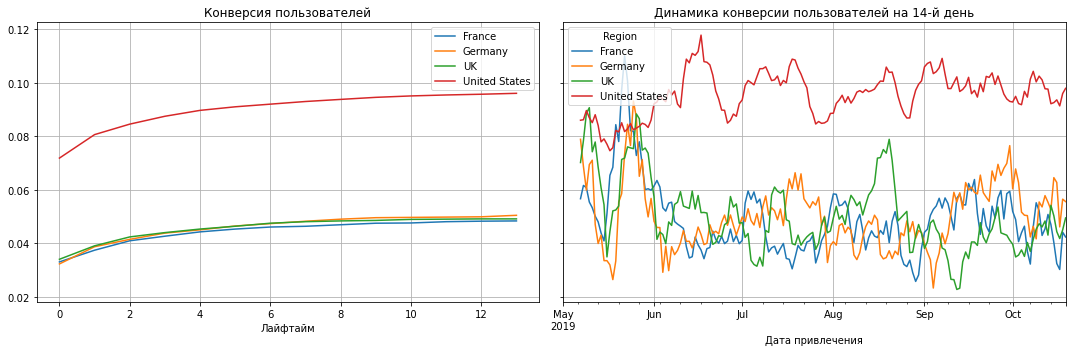

In [32]:
plot_conversion(conversion, conversion_history, 14)

- Конверсия по странам выше всего в США.

In [33]:
def get_retention(df_cac, visits, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    dimensions = ['payer'] + dimensions
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = df_cac.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(visits[['User Id', 'Session Start']], on = 'User Id', how = 'left')
    result_raw['lifetime'] = (result_raw['Session Start'] - result_raw['first_ts']).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'User Id', aggfunc = 'nunique')     
        cohort_sizes = df.groupby(dims).agg({'User Id': 'nunique'}).rename(columns = {'User Id': 'cohort_size'}) 
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   
        result = result.div(result['cohort_size'], axis = 0)                                                     
        result = result[['cohort_size'] + list(range(horizon_days))]                                             
        result['cohort_size'] = cohort_sizes                                                                     
        return result
     
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time

In [34]:
retention_raw, retention, retention_history = get_retention(
    df_cac2, visits, observation_date, 14, dimensions=['Channel']
)

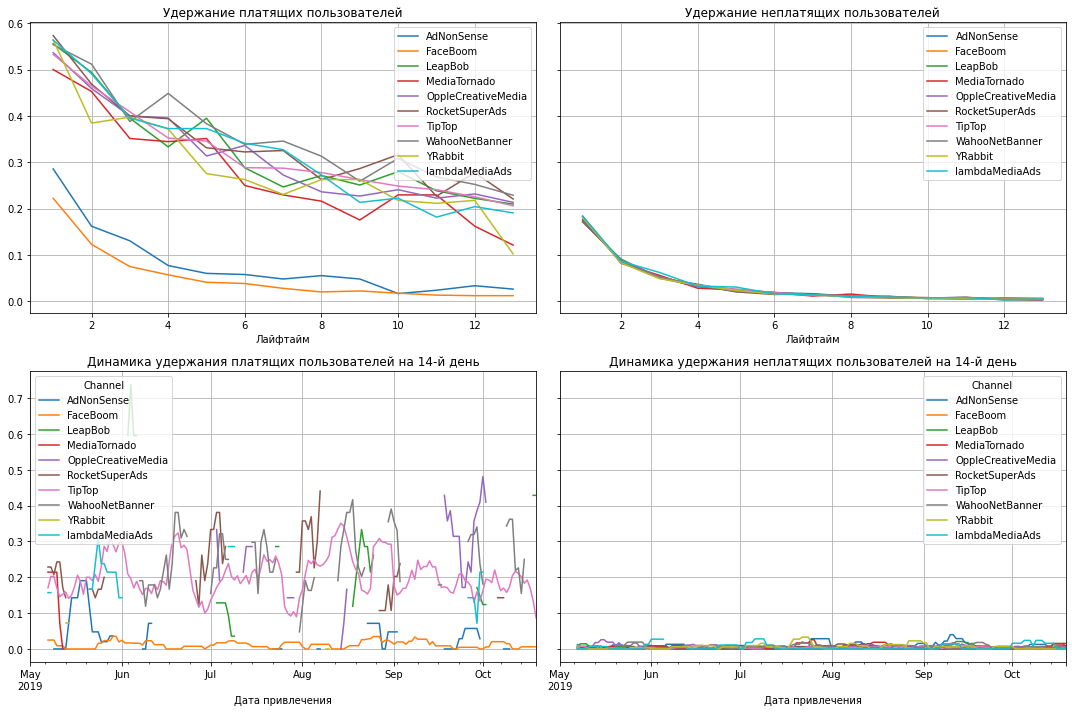

In [35]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

plot_retention(retention, retention_history, 14)

- Удержание платящих пользователей выше всего у WahooNetBanner, а ниже всего у FaceBoom.

In [36]:
retention_raw, retention, retention_history = get_retention(
    df_cac2, visits, observation_date, 14, dimensions=['Region']
)

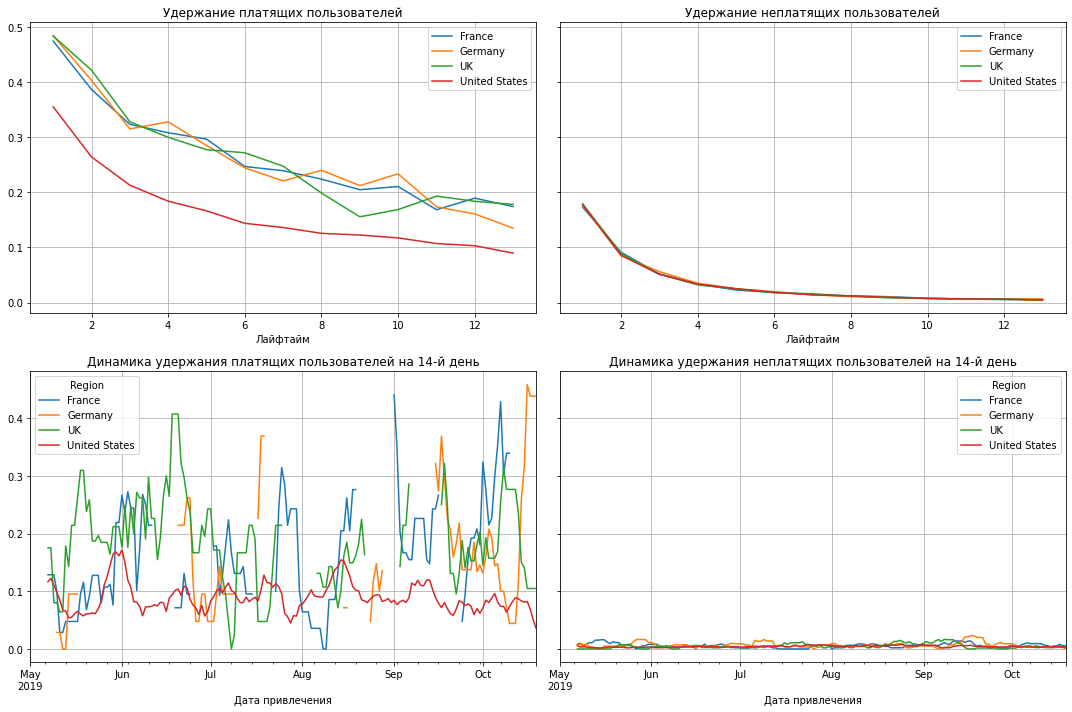

In [37]:
plot_retention(retention, retention_history, 14)

- Удержание платящих пользователей выше всего во Франции и Англии, а ниже всего в США.

In [38]:
retention_raw, retention, retention_history = get_retention(
    df_cac2, visits, observation_date, 14, dimensions=['Device']
)

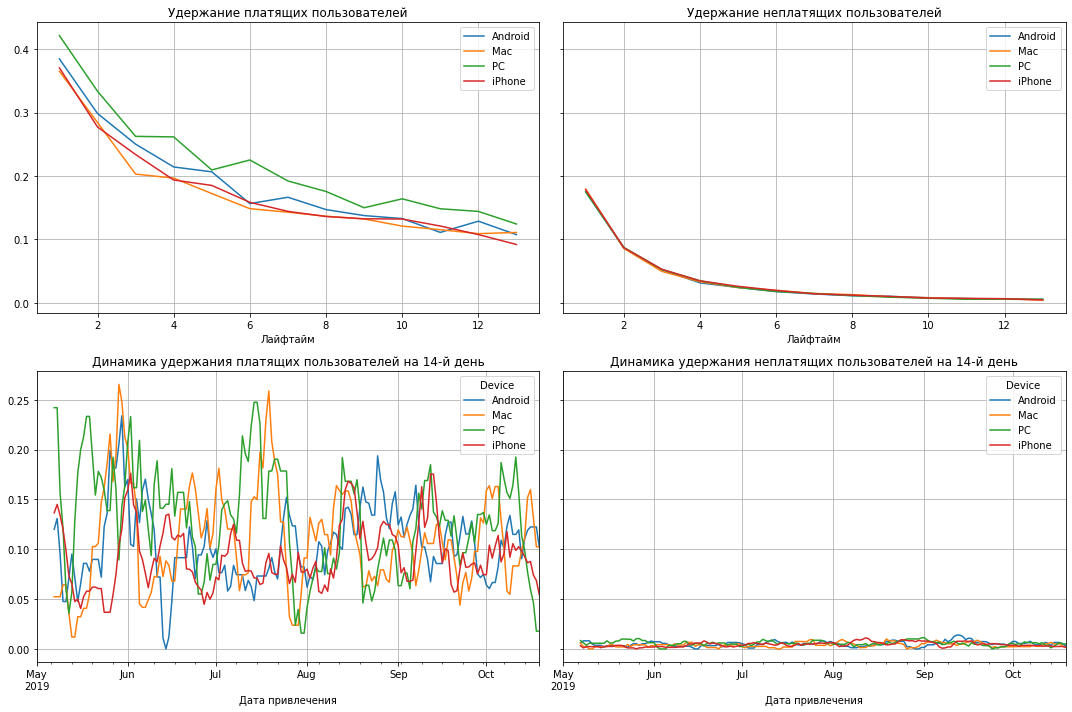

In [39]:
plot_retention(retention, retention_history, 14)

- Удержание платящих пользователей PC выше всех.

### Анализ окупаемости рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

In [40]:
def get_ltv(
    df_cac,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
        
    result_raw = df_cac.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        orders[['User Id', 'Event Dt', 'Revenue']], on='User Id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['Event Dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='Revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['User Id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  
        result_grouped,  
        result_in_time,  
        roi_grouped,  
        roi_in_time,  
    )

In [41]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    df_cac2, orders, observation_date, 14, dimensions=['Channel']
)

### Окупаемость рекламы с разбивкой по рекламным каналам

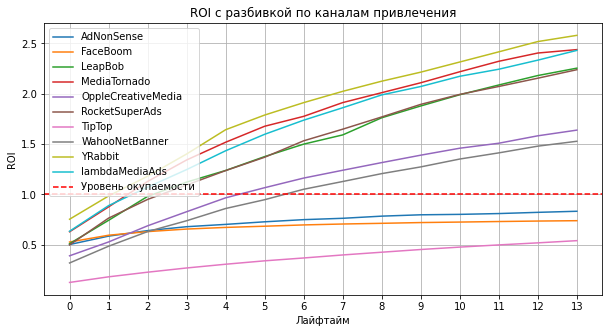

In [42]:
report = roi.drop(columns=['cohort_size', 'cac'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

- Инвестиции через каналы AdNonSense, FaceBoom и TipTop не окупаются.

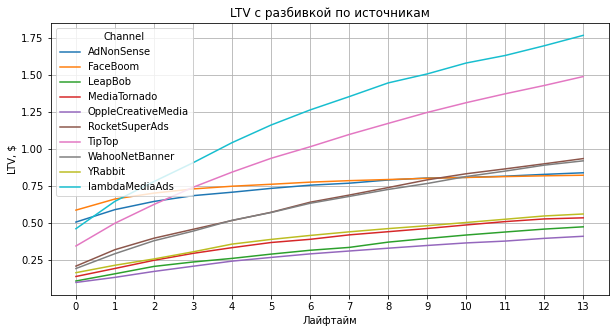

In [43]:
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('LTV с разбивкой по источникам')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')
plt.show()

- Пожизненная ценность клиента с разбивкой по каналам привлеченя AdNonSense и TipTop выше всего.

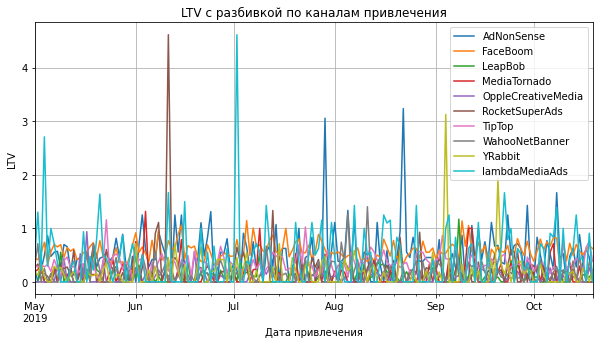

In [44]:
ltv_history.pivot_table(
    index='dt', columns='Channel', values=0, aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.title('LTV с разбивкой по каналам привлечения')
plt.ylabel('LTV')
plt.xlabel('Дата привлечения')
plt.legend()
plt.show()

- За последний месяц LTV была на высоком уровне у каналов AdNonSense, lambdaMediaAds и FaceBoom.

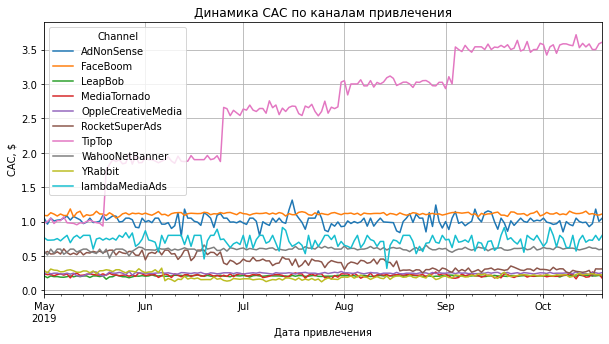

In [45]:
roi_history.pivot_table(
    index='dt', columns='Channel', values='cac', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

- Стоимость привлечения клиентов у TipTiop за последний месяц была выше из всех каналов.

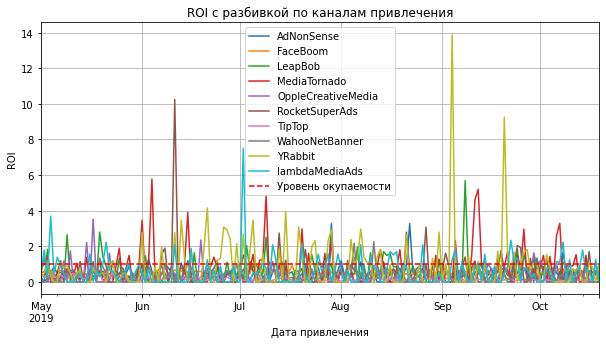

In [46]:
roi_history.pivot_table(
    index='dt', columns='Channel', values=0, aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Дата привлечения')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

- Динамика окупаемости показывает, что достаточно часто за последний месяц реклама окуалась через канал MediaTornado.

### Анализ окупаемости рекламы с разбивкой по странам

In [47]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    df_cac2, orders, observation_date, 14, dimensions=['Region']
)

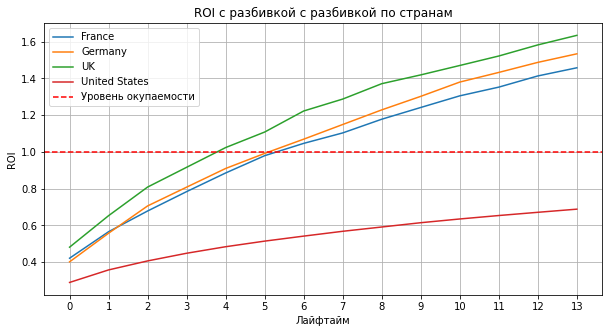

In [48]:
report = roi.drop(columns=['cohort_size', 'cac'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI с разбивкой с разбивкой по странам')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

- Инвестициии в США не окупаются.

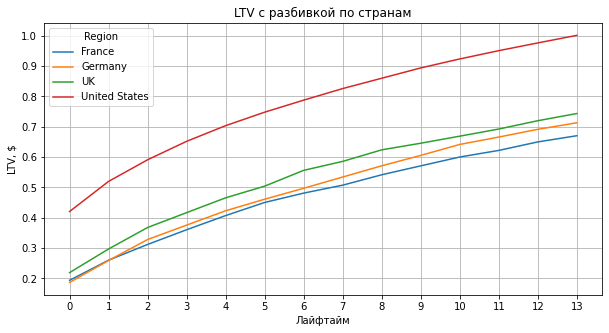

In [49]:
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('LTV с разбивкой по странам')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')
plt.show()

- LTV в США выше чем в других странах.

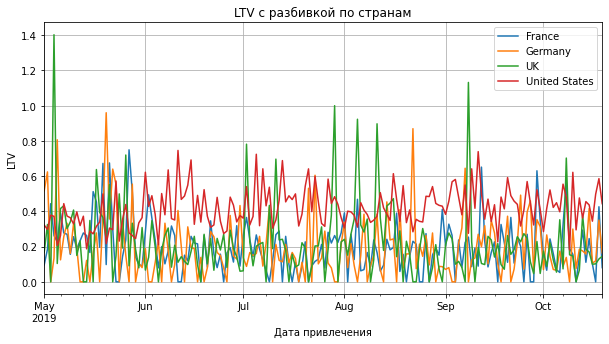

In [50]:
ltv_history.pivot_table(
    index='dt', columns='Region', values=0, aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.title('LTV с разбивкой по странам')
plt.ylabel('LTV')
plt.xlabel('Дата привлечения')
plt.legend()
plt.show()

- Динамика LTV в США за последний месяц былла выше, чем в других странах.

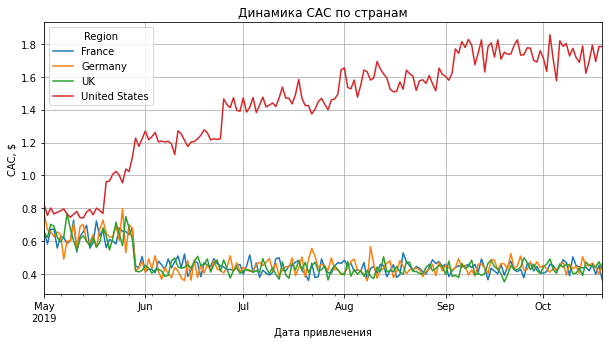

In [51]:
roi_history.pivot_table(
    index='dt', columns='Region', values='cac', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по странам')
plt.show()

- Стоимость привлечения клиентов в США была значительно выше, чем в других странах.

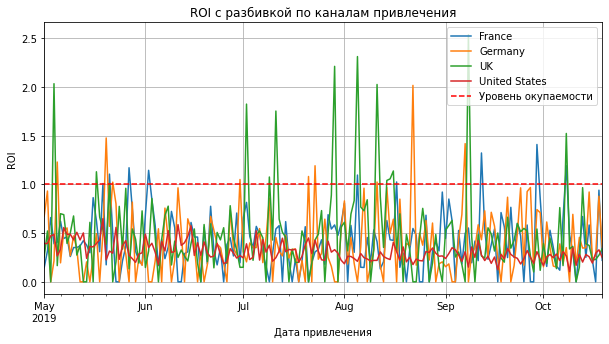

In [52]:
roi_history.pivot_table(
    index='dt', columns='Region', values=0, aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Дата привлечения')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

- Динамика ROI в США была на стабильно ниизком уровне, а в другиз странах иногда выходила за уровень окупаемости.

### Анализ окупаемости рекламы с разбивкой по устройствам

In [53]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    df_cac2, orders, observation_date, 14, dimensions=['Device']
)

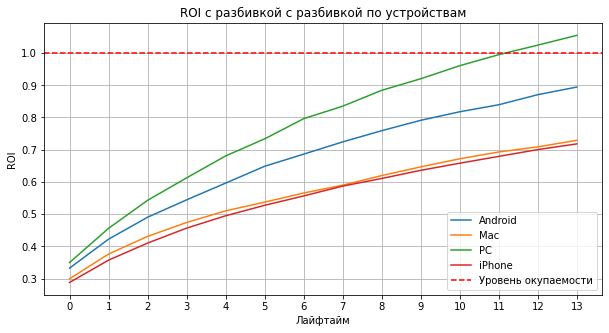

In [54]:
report = roi.drop(columns=['cohort_size', 'cac'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI с разбивкой с разбивкой по устройствам')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

- Реклама через ПК окупается, у остальных нет.

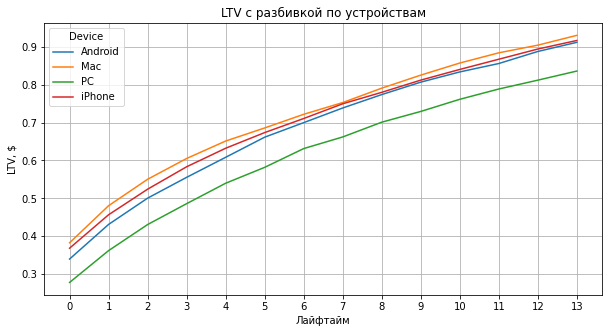

In [55]:
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('LTV с разбивкой по устройствам')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')
plt.show()

- LTV на ПК ниже, чем на других устройствах.

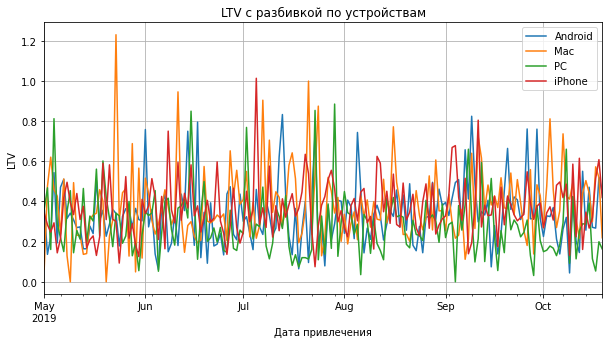

In [56]:
ltv_history.pivot_table(
    index='dt', columns='Device', values=0, aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.title('LTV с разбивкой по устройствам')
plt.ylabel('LTV')
plt.xlabel('Дата привлечения')
plt.legend()
plt.show()

- Динамика LTV на ПК ниже, чем на других устройствах.

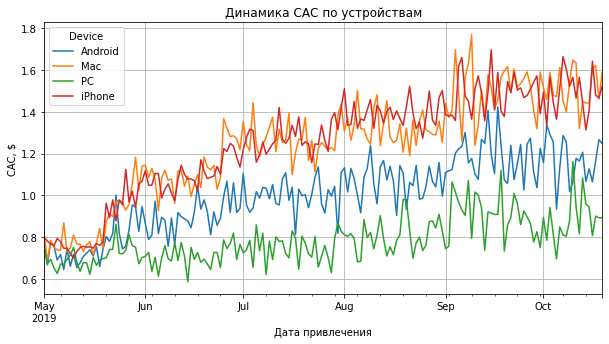

In [57]:
roi_history.pivot_table(
    index='dt', columns='Device', values='cac', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по устройствам')
plt.show()

- Стоимость привлечения клиентов на Mac и iPhone выше, чем на других устройствах.

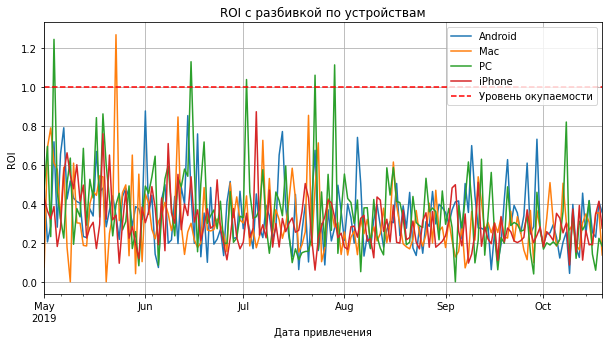

In [58]:
roi_history.pivot_table(
    index='dt', columns='Device', values=0, aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.title('ROI с разбивкой по устройствам')
plt.ylabel('ROI')
plt.xlabel('Дата привлечения')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

- Динамика ROI показывает, общая окупаемость падает, но у Андроид И ПК периодически повышается.

### Оценка:

Окупается ли реклама, направленная на привлечение пользователей в целом?
- В целом реклама окупается на ПК и Андроидах в большинстве странах и через основные каналы привлечения.

Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- В США, через Mac и iPhone, и через каналы AdNonSense, FaceBoom и TipTop реклама не окупается.

Чем могут быть вызваны проблемы окупаемости?
- Проблемы могут быть вываны черезмерными вложениями в рекламу и большую стоимость привлечения клиентов, что может быть не совсем целесообразно.

## Выводы:


- Основная причина неэффективности привлечения пользователей - это нецелесообразные вложения в привлечение клиентов через те каналы, страны и устройства, которые не привносят значительный вклад в привлечение клиентов.

- Основная рекомендация - направить финансы в те когорты, которые вносят достаточных вклад в привлечение клиентов.